# Importing Libraries

In [149]:
import os
from tqdm import tqdm

import cv2
import numpy as np
import pandas as pd
from scipy.spatial import distance

from cv2 import HOGDescriptor
from skimage.feature import hog as skhog

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import joblib

import seaborn as sns
import matplotlib.pyplot as plt
from skimage import exposure
from matplotlib.colors import Normalize

# Loading Data

In [2]:
# Image Directory
img_dir = "data/"

# Data Groups
grps = ["train", "test"]

# Initializing a Dataframe to store paths and labels
column_names = ["ort", "grp", "path", "label", "label_int", "filename"]
data = pd.DataFrame(columns = column_names)

# Class Labels
class_names = []

for path in sorted([f for f in os.listdir(img_dir) if not f.startswith('.')]):
    # Get class name
    class_names.append(path)
    
    # Get all train images in the class
    with open(img_dir + path + "/train.txt") as f:
        for line in f:
            for orientation in [0, 90, 180, 270]:
                row = pd.DataFrame({'ort': orientation,
                                    'grp': ['train'], 
                                    'path': [os.path.join(img_dir, path, line.strip())], 
                                    'label': [path], 
                                    'label_int': [class_names.index(path)], 
                                    'filename': [line.strip()]})
                data = pd.concat([data, row], ignore_index=True, axis=0)

    # Get all test images in the class
    with open(img_dir + path + "/test.txt") as f:
        for line in f:
            for orientation in [0, 90, 180, 270]:
                row = pd.DataFrame({'ort': orientation,
                                    'grp': ['test'], 
                                    'path': [os.path.join(img_dir, path, line.strip())], 
                                    'label': [path], 
                                    'label_int': [class_names.index(path)], 
                                    'filename': [line.strip()]})
                data = pd.concat([data, row], ignore_index=True, axis=0)

# Printing Useful information
print("Data Shape: ", data.shape)
print("Labels: ", data.label.unique(),  data.label_int.unique())

print("Dataset:")
data.head(8)

Data Shape:  (4000, 6)
Labels:  ['00001' '00002' '00003' '00004' '00005' '00006' '00007' '00008' '00009'
 '00010'] [0 1 2 3 4 5 6 7 8 9]
Dataset:


,ort,grp,path,label,label_int,filename
0,0,train,data/00001/00468_00002.ppm,00001,0,00468_00002.ppm
1,90,train,data/00001/00468_00002.ppm,00001,0,00468_00002.ppm
2,180,train,data/00001/00468_00002.ppm,00001,0,00468_00002.ppm
3,270,train,data/00001/00468_00002.ppm,00001,0,00468_00002.ppm
4,0,train,data/00001/00475_00000.ppm,00001,0,00475_00000.ppm
5,90,train,data/00001/00475_00000.ppm,00001,0,00475_00000.ppm
6,180,train,data/00001/00475_00000.ppm,00001,0,00475_00000.ppm
7,270,train,data/00001/00475_00000.ppm,00001,0,00475_00000.ppm


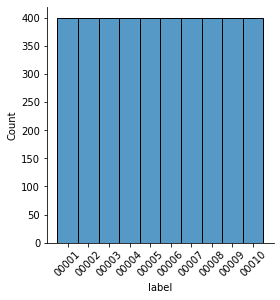

In [3]:
ax = sns.displot(data=data, x='label', height=4)
ax.set_xticklabels(rotation=45)

# Loading Images

In [4]:
img_width = 100
img_height = 100
dim = (img_width, img_height)

# Initializing images column
data['img_read'] = np.nan
data['img_read'] = data['img_read'].astype(object)

# Printing Info
print("[INFO] Importing Images")

# Iterating on all rows and reading image data
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
    img = cv2.imread(row.path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, dim)
    data.at[index, 'img_read'] = img

[INFO] Importing Images


100%|██████████| 4000/4000 [00:00<00:00, 8992.36it/s]


# Viewing Images

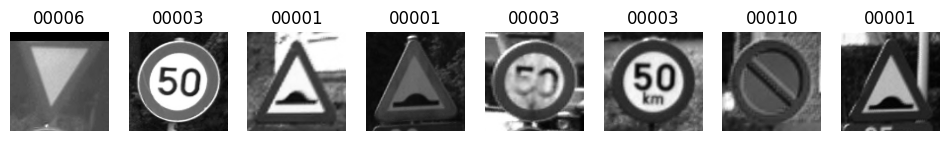

In [5]:
row = 1
col = 8

fig, axes = plt.subplots(row, col, figsize=(1.5*col,2*row))
for (index, data_sample), i in zip(data.sample(8).iterrows(), range(8)):
    ax = axes[i]
    ax.imshow(data_sample["img_read"], "gray")
    ax.set_title(data_sample.label)
    ax.axis("off") 
plt.show()

# Initialization of Feature Descriptor: 
# <span style="color:yellow">HOG (Histogram of Gradients) Descriptor</span>

### Visualization of HOG Descriptor

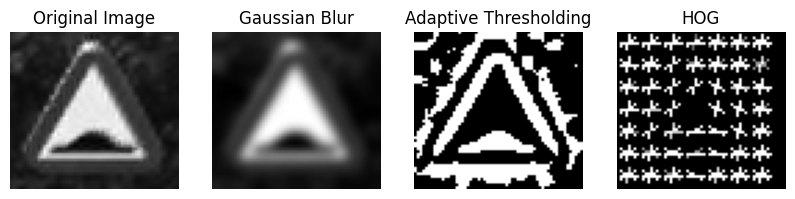

In [212]:
# Reading the image
img_data = cv2.imread("data/00001/00025_00000.ppm", 0)

# Applying Gaussion Blur
gauss_img = cv2.GaussianBlur(img_data,(9,9),0)

# Applying Thresholding (Adaptive and Binary Inverse)
th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                        cv2.THRESH_BINARY_INV, 11, 2)

# Computing Hog Descriptors
fd, hog_image = skhog(th, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
for ax in axes:
    ax.axis("off")
    axes[0].imshow(img_data, cmap=plt.cm.gray)
    axes[0].set_title("Original Image")
    axes[1].imshow(gauss_img, cmap=plt.cm.gray)
    axes[1].set_title("Gaussian Blur")
    axes[2].imshow(th, cmap=plt.cm.gray)
    axes[2].set_title("Adaptive Thresholding")
    axes[3].imshow( exposure.rescale_intensity(hog_image, in_range=(0, 10)), cmap=plt.cm.gray)
    axes[3].set_title("HOG")

### Adjusting the parameters of HOG Descriptor

In [6]:
# winSize: This parameter is set to 100×100 because the size of ROI in images in our dataset 
# is 100×1000 and we want to calculate one descriptor for the entire image.
winSize = (100,100)

# cellSize: Our ROI is 100×100 grayscale images. In other words, our image is represented 
# by 100×100 = 10000 numbers. The size of descriptor typically is much smaller than the 
# number of pixels in an image. The cellSize is chosen based on the scale of the features 
# important to do the classification. A very small cellSize would blow up the size of the 
# feature vector and a very large one may not capture relevant information. 
# This parameter is set to 10×10.
cellSize = (10,10)

# blockSize: The notion of blocks exist to tackle illumination variation. A large block size 
# makes local changes less significant while a smaller block size weights local changes more. 
# Typically blockSize is set to 2 x cellSize, but in our case of classification, 
# illumination does not present much of a challenge.
# This parameter is set to 10×10.
blockSize = (10,10)

# blockStride: The blockStride determines the overlap between neighboring blocks and controls 
# the degree of contrast normalization. Typically a blockStride is set to 50% of blockSize.
blockStride = (5,5)

# nbins: nbins sets the number of bins in the histogram of gradients. The authors of the 
# HOG paper had recommended a value of 9 to capture gradients between 0 and 180 degrees 
# in 20 degrees increments.
nbins = 9

# signedGradient: Typically gradients can have any orientation between 0 and 360 degrees. 
# These gradients are referred to as “signed” gradients as opposed to “unsigned” gradients 
# that drop the sign and take values between 0 and 180 degrees. In the original HOG paper, 
# unsigned gradients were used for pedestrian detection. Signed gradients produced slightly 
# better results.
signedGradient = True

# derivAperture, winSigma, histogramNormType, L2HysThreshold, gammaCorrection and nlevels 
# are not modified. Unless you have carefully read the original HOG paper, It is recommended 
# you go with the default values

# Initializing HOG Descriptor
hog = HOGDescriptor(_winSize=winSize,
                    _blockSize=blockSize,
                    _blockStride=blockStride,
                    _cellSize=cellSize,
                    _nbins=nbins,
                    _signedGradient=signedGradient)

### Calculating HOG Descriptor for Train Data

In [7]:
# Train Data Selection
trainData = data[(data['grp'] == "train") & (data['ort'] == 0)]
trainLabels = data[data['grp'] == "train"]["label_int"].tolist()

# Initalize Hog Descriptors
hog_descriptors = []

for index, row in trainData.iterrows():
    # Getting Image Data
    img_data = row["img_read"]

    # Applying Gaussion Blur
    gauss_img = cv2.GaussianBlur(img_data,(9,9),0)

    # Applying Thresholding (Adaptive and Binary Inverse)
    th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

    # Computing Hog Descriptors
    hog_descriptors.append(hog.compute(th))

    # For all four orientations of an image
    rows,cols = img_data.shape
    for i in [1,2,3]:
        # Rotate Images in all four orientations
        M   = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        dst = cv2.warpAffine(th,M,(cols,rows))
        hog_descriptors.append(hog.compute(dst))

### Calculating HOG Descriptor for Test Data

In [8]:
# Test Data Selection
testData = data[(data['grp'] == "test") & (data['ort'] == 0)]
testLabels = data[data['grp'] == "test"]["label_int"].tolist()

# Initalize Hog Descriptors
test_hog_descriptors = []

for index, row in testData.iterrows():
    # Getting Image Data
    img_data = row["img_read"]

    # Applying Gaussion Blur
    gauss_img = cv2.GaussianBlur(img_data,(9,9),0)

    # Applying Thresholding (Adaptive and Binary Inverse)
    th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 11, 2)

    # Computing Hog Descriptors
    test_hog_descriptors.append(hog.compute(th))

    # For all four orientations of an image
    rows,cols = img_data.shape
    for i in [1,2,3]:
        # Rotate Images in all four orientations
        M   = cv2.getRotationMatrix2D((cols/2,rows/2),i*90,1)
        dst = cv2.warpAffine(th,M,(cols,rows))
        test_hog_descriptors.append(hog.compute(dst))

# Classification using SVM

### Train Data

In [9]:
X = np.array(hog_descriptors, np.float32)
y = np.array(trainLabels)

### Model Training

In [10]:
# Defining SVM GridSearch Parameters
kernels = ['linear', 'rbf', 'sigmoid']
C_range = np.logspace(-2, 10, 5)
gamma_range = np.logspace(-9, 3, 5)
param_grid = dict(kernel=kernels, gamma=gamma_range, C=C_range)

# Cross Validation
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# Model Fitting
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, verbose=3, n_jobs=-1)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV 2/5] END C=0.01, gamma=1e-09, kernel=linear;, score=0.991 total time=  17.8s
[CV 5/5] END C=0.01, gamma=1e-09, kernel=linear;, score=0.997 total time=  17.9s
[CV 1/5] END C=0.01, gamma=1e-09, kernel=linear;, score=0.994 total time=  17.9s
[CV 4/5] END C=0.01, gamma=1e-09, kernel=linear;, score=0.995 total time=  17.9s
[CV 3/5] END C=0.01, gamma=1e-09, kernel=linear;, score=0.991 total time=  17.9s
[CV 3/5] END ...C=0.01, gamma=1e-09, kernel=rbf;, score=0.927 total time= 1.1min
[CV 1/5] END ...C=0.01, gamma=1e-09, kernel=rbf;, score=0.928 total time= 1.1min
[CV 2/5] END ...C=0.01, gamma=1e-09, kernel=rbf;, score=0.898 total time= 1.1min
[CV 3/5] END C=0.01, gamma=1e-09, kernel=sigmoid;, score=0.922 total time=  59.9s
[CV 2/5] END C=0.01, gamma=1e-09, kernel=sigmoid;, score=0.906 total time= 1.0min
[CV 1/5] END C=0.01, gamma=1e-09, kernel=sigmoid;, score=0.931 total time= 1.0min
[CV 5/5] END ...C=0.01, gamma=1e-09, kernel=

### Model Evaluation

In [61]:
# Model Evaluation
results_df = pd.DataFrame(grid.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

score_linear = []
score_rbf = []
score_sigmoid = []

for index, row in results_df.iterrows():
    if row["params"]["kernel"] == "linear":
        score_linear.append(row["mean_test_score"])
    elif row["params"]["kernel"] == "rbf":
        score_rbf.append(row["mean_test_score"])
    elif row["params"]["kernel"] == "sigmoid":
        score_sigmoid.append(row["mean_test_score"])

score_rbf = np.array(score_rbf).reshape(5,5)
score_linear = np.array(score_linear).reshape(5,5)
score_sigmoid = np.array(score_sigmoid).reshape(5,5)

scores = [score_linear, score_rbf, score_sigmoid]

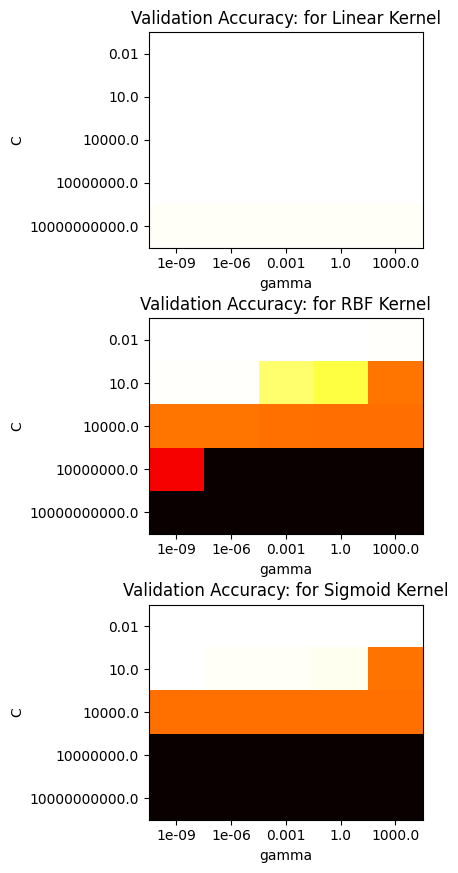

In [82]:
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Plotting Heatmaps
fig, axes = plt.subplots(3, 1, figsize=(4,9))
fig.tight_layout(pad=3.0)
for ax, score, title in zip(axes, scores, ["Linear", "RBF", "Sigmoid"]):
    im = ax.imshow(score, 
                   interpolation='nearest', 
                   cmap=plt.cm.hot,
                   norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    ax.set_title("Validation Accuracy: for " + title + " Kernel")
    ax.set_xlabel('gamma')
    ax.set_ylabel('C')
    ax.set_xticks(np.arange(len(gamma_range)))
    ax.set_yticks(np.arange(len(C_range)))
    ax.set_xticklabels(gamma_range)
    ax.set_yticklabels(C_range)
    ax.set_aspect('auto')

### Save Model

In [167]:
# Save your model or results
joblib.dump(grid, 'models/hog_svm.pkl')

['models/hog_svm.pkl']

### Load Model

In [168]:
# Load your model or results
#grid = joblib.load('models/hog_svm.pkl')

### Model Testing

In [169]:
testLabels_pred = []
for hog_des in test_hog_descriptors:
    result = grid.predict(np.array(hog_des,np.float32).reshape(-1,3249))
    idx = int(result)
    testLabels_pred.append(idx)

In [170]:
print(classification_report(testLabels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       1.00      1.00      1.00        80
       00002       0.95      1.00      0.98        80
       00003       1.00      0.95      0.97        80
       00004       1.00      1.00      1.00        80
       00005       1.00      1.00      1.00        80
       00006       1.00      1.00      1.00        80
       00007       1.00      1.00      1.00        80
       00008       1.00      0.99      0.99        80
       00009       0.99      1.00      0.99        80
       00010       1.00      1.00      1.00        80

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



<AxesSubplot:>

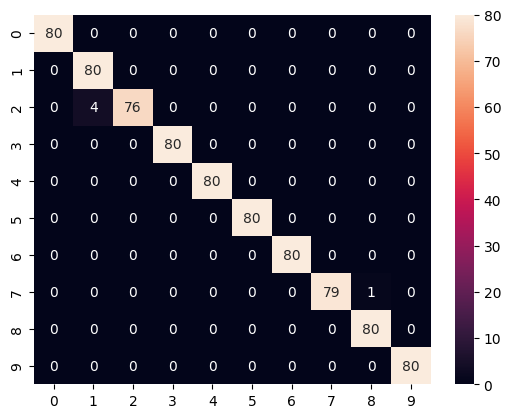

In [171]:
sns.heatmap(confusion_matrix(testLabels, testLabels_pred), annot = True)

### Manual Testing

Predicted Label: 2 Expected Label: 2


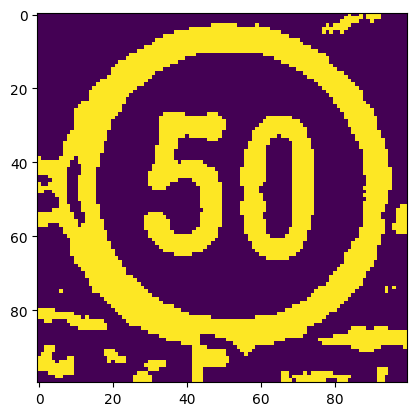

In [172]:
# Getting Image Data
img_data = cv2.imread("test/test1.png", 0)

# Resize image and interpolate
resized_img = cv2.resize(img_data,(100,100),interpolation = cv2.INTER_CUBIC)

# Applying Gaussion Blur
gauss_img = cv2.GaussianBlur(resized_img,(9,9),0)

# Applying Thresholding (Adaptive and Binary Inverse)
th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

plt.imshow(th)

hog_des = hog.compute(th)

result = grid.predict(np.array(hog_des,np.float32).reshape(-1,3249))

idx = int(result)

print("Predicted Label:", idx, "Expected Label: 2")

Predicted Label: 0 Expected Label: 0


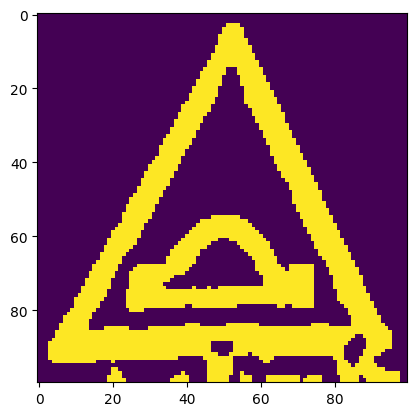

In [173]:
# Getting Image Data
img_data = cv2.imread("test/test2.png", 0)

# Resize image and interpolate
resized_img = cv2.resize(img_data,(100,100),interpolation = cv2.INTER_CUBIC)

# Applying Gaussion Blur
gauss_img = cv2.GaussianBlur(resized_img,(9,9),0)

# Applying Thresholding (Adaptive and Binary Inverse)
th = cv2.adaptiveThreshold(gauss_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

plt.imshow(th)

hog_des = hog.compute(th)

result = grid.predict(np.array(hog_des,np.float32).reshape(-1,3249))

idx = int(result)

print("Predicted Label:", idx, "Expected Label: 0")

# Classification using Naive Bayes

### Train Data

In [174]:
X = np.array(hog_descriptors, np.float32)
y = np.array(trainLabels)

### Model Training

In [175]:
clf = GaussianNB()
clf.fit(X, y)

GaussianNB()

### Save Model

In [176]:
# Save your model or results
joblib.dump(clf, 'models/hog_nb.pkl')

['models/hog_nb.pkl']

### Load Model

In [177]:
# Load your model or results
#clf = joblib.load('models/hog_nb.pkl')

### Model Testing

In [178]:
testLabels_pred = []
for hog_des in test_hog_descriptors:
    result = clf.predict(np.array(hog_des,np.float32).reshape(-1,3249))
    idx = int(result)
    testLabels_pred.append(idx)

In [179]:
print(classification_report(testLabels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.94      0.93      0.93        80
       00002       0.60      0.81      0.69        80
       00003       0.69      0.59      0.64        80
       00004       1.00      1.00      1.00        80
       00005       1.00      1.00      1.00        80
       00006       0.93      0.94      0.93        80
       00007       1.00      0.79      0.88        80
       00008       1.00      1.00      1.00        80
       00009       1.00      1.00      1.00        80
       00010       0.99      1.00      0.99        80

    accuracy                           0.91       800
   macro avg       0.91      0.91      0.91       800
weighted avg       0.91      0.91      0.91       800



<AxesSubplot:>

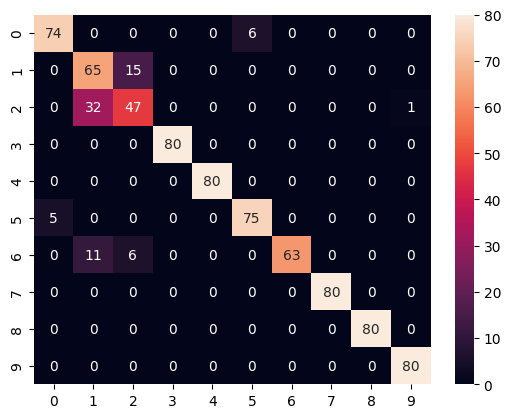

In [180]:
sns.heatmap(confusion_matrix(testLabels, testLabels_pred), annot = True)

# Classification using KNN

### Train Data

In [181]:
X = np.array(hog_descriptors, np.float32)
y = np.array(trainLabels)

### Model Training

In [182]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

### Save Model

In [183]:
# Save your model or results
joblib.dump(clf, 'models/hog_knn.pkl')

['models/hog_knn.pkl']

### Load Model

In [184]:
# Load your model or results
#clf = joblib.load('models/hog_nb.pkl')

### Model Testing

In [186]:
testLabels_pred = []
for hog_des in test_hog_descriptors:
    result = clf.predict(np.array(hog_des,np.float32).reshape(-1,3249))
    idx = int(result)
    testLabels_pred.append(idx)

In [187]:
print(classification_report(testLabels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       1.00      1.00      1.00        80
       00002       0.97      0.86      0.91        80
       00003       0.82      1.00      0.90        80
       00004       0.99      1.00      0.99        80
       00005       1.00      1.00      1.00        80
       00006       1.00      0.99      0.99        80
       00007       1.00      0.94      0.97        80
       00008       1.00      1.00      1.00        80
       00009       1.00      1.00      1.00        80
       00010       1.00      0.95      0.97        80

    accuracy                           0.97       800
   macro avg       0.98      0.97      0.97       800
weighted avg       0.98      0.97      0.97       800



<AxesSubplot:>

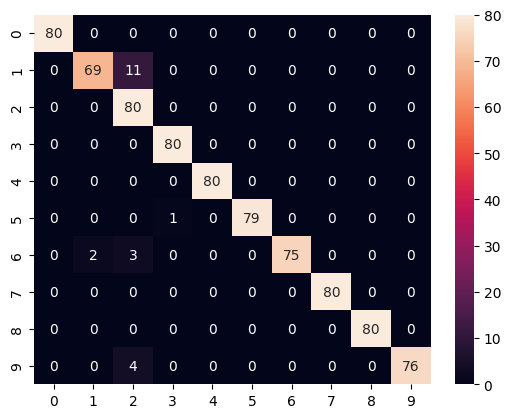

In [188]:
sns.heatmap(confusion_matrix(testLabels, testLabels_pred), annot = True)

# Classification using Random Forest

### Train Data

In [189]:
X = np.array(hog_descriptors, np.float32)
y = np.array(trainLabels)

### Model Training

In [190]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

### Save Model

In [191]:
# Save your model or results
joblib.dump(clf, 'models/hog_rf.pkl')

['models/hog_rf.pkl']

### Load Model

In [192]:
# Load your model or results
#clf = joblib.load('models/hog_nb.pkl')

### Model Testing

In [193]:
testLabels_pred = []
for hog_des in test_hog_descriptors:
    result = clf.predict(np.array(hog_des,np.float32).reshape(-1,3249))
    idx = int(result)
    testLabels_pred.append(idx)

In [194]:
print(classification_report(testLabels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       0.52      0.99      0.68        80
       00002       1.00      0.03      0.05        80
       00003       0.44      1.00      0.61        80
       00004       0.72      1.00      0.84        80
       00005       0.99      1.00      0.99        80
       00006       0.89      0.10      0.18        80
       00007       0.96      0.85      0.90        80
       00008       0.68      0.84      0.75        80
       00009       0.79      0.81      0.80        80
       00010       1.00      0.17      0.30        80

    accuracy                           0.68       800
   macro avg       0.80      0.68      0.61       800
weighted avg       0.80      0.68      0.61       800



<AxesSubplot:>

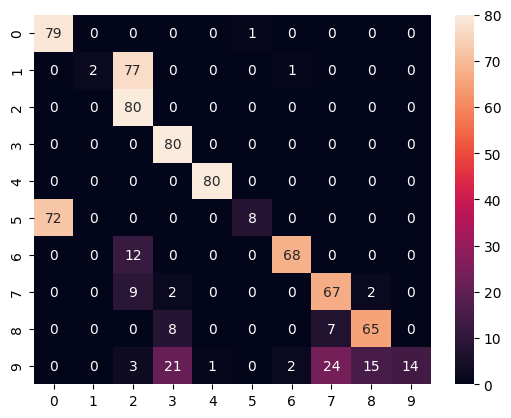

In [195]:
sns.heatmap(confusion_matrix(testLabels, testLabels_pred), annot = True)

# Classification using Logistic Regression

### Train Data

In [196]:
X = np.array(hog_descriptors, np.float32)
y = np.array(trainLabels)

### Model Training

In [197]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X, y)

/Users/hasaniqbal/.pyenv/versions/3.9.11/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial', random_state=0)

### Save Model

In [198]:
# Save your model or results
joblib.dump(clf, 'models/hog_lr.pkl')

['models/hog_lr.pkl']

### Load Model

In [199]:
# Load your model or results
#clf = joblib.load('models/hog_nb.pkl')

### Model Testing

In [200]:
testLabels_pred = []
for hog_des in test_hog_descriptors:
    result = clf.predict(np.array(hog_des,np.float32).reshape(-1,3249))
    idx = int(result)
    testLabels_pred.append(idx)

In [201]:
print(classification_report(testLabels, testLabels_pred, target_names=data['label'].unique()))

              precision    recall  f1-score   support

       00001       1.00      1.00      1.00        80
       00002       0.96      1.00      0.98        80
       00003       1.00      0.99      0.99        80
       00004       1.00      1.00      1.00        80
       00005       1.00      1.00      1.00        80
       00006       1.00      1.00      1.00        80
       00007       1.00      0.97      0.99        80
       00008       1.00      0.99      0.99        80
       00009       0.99      1.00      0.99        80
       00010       1.00      1.00      1.00        80

    accuracy                           0.99       800
   macro avg       1.00      0.99      1.00       800
weighted avg       1.00      0.99      1.00       800



<AxesSubplot:>

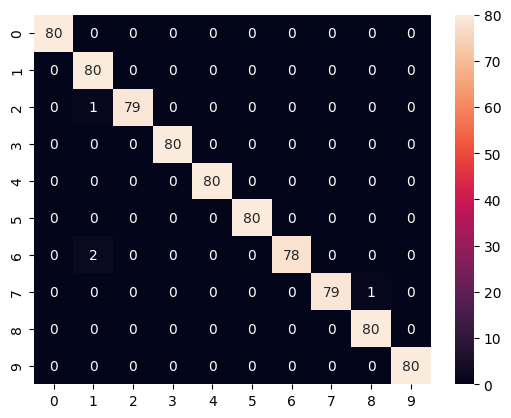

In [202]:
sns.heatmap(confusion_matrix(testLabels, testLabels_pred), annot = True)